# 16. 프로젝트: 다음에 볼 영화 예측하기


## 목차

>   <p style="font-size:17px">Step 1. 데이터의 전처리</p>
    <p style="font-size:17px">Step 2. 미니 배치의 구성</p> 
    <p style="font-size:17px">Step 3. 모델 구성</p>
    <p style="font-size:17px">Step 4. 모델 학습</p>
    <p style="font-size:17px">Step 5. 모델 테스트</p>


## 루브릭 (프로젝트 평가 기준)

> |<p style="font-size:15px"> 평가문항 </p>                                |<p style="font-size:15px"> 상세기준 </p>        |
  |------------------------------------------------------------------------|------------------------------------------------|
  |1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다. | 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
  |2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다. | 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
  |3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다. | 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|

# 1. 데이터 전처리

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [3]:
#총 6040개의 UserID, 3706개의 ItemID 그리고 458455개의 사용시간이 있습니다.
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
df = data.groupby('UserId').size()
df

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
# 한명의 유저가 평균적으로 약 165편의 영화를 시청했다고 생각할 수 있습니다. 
df.median(), df.mean()


(96.0, 165.5975165562914)

In [6]:
df.min(), df.max()


(20, 2314)

In [7]:
df.quantile(0.999)


1343.181000000005

In [8]:
long_session = df[df==2314].index[0]
data[data['UserId']==long_session].head(20)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
696168,4169,3801,5,2000-08-03 20:11:21
696250,4169,3841,2,2000-08-03 20:11:21
697903,4169,3761,3,2000-08-03 20:11:21
697954,4169,3788,3,2000-08-03 20:11:21
695653,4169,3794,4,2000-08-03 20:11:59


In [9]:
length_count = df.groupby(df).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

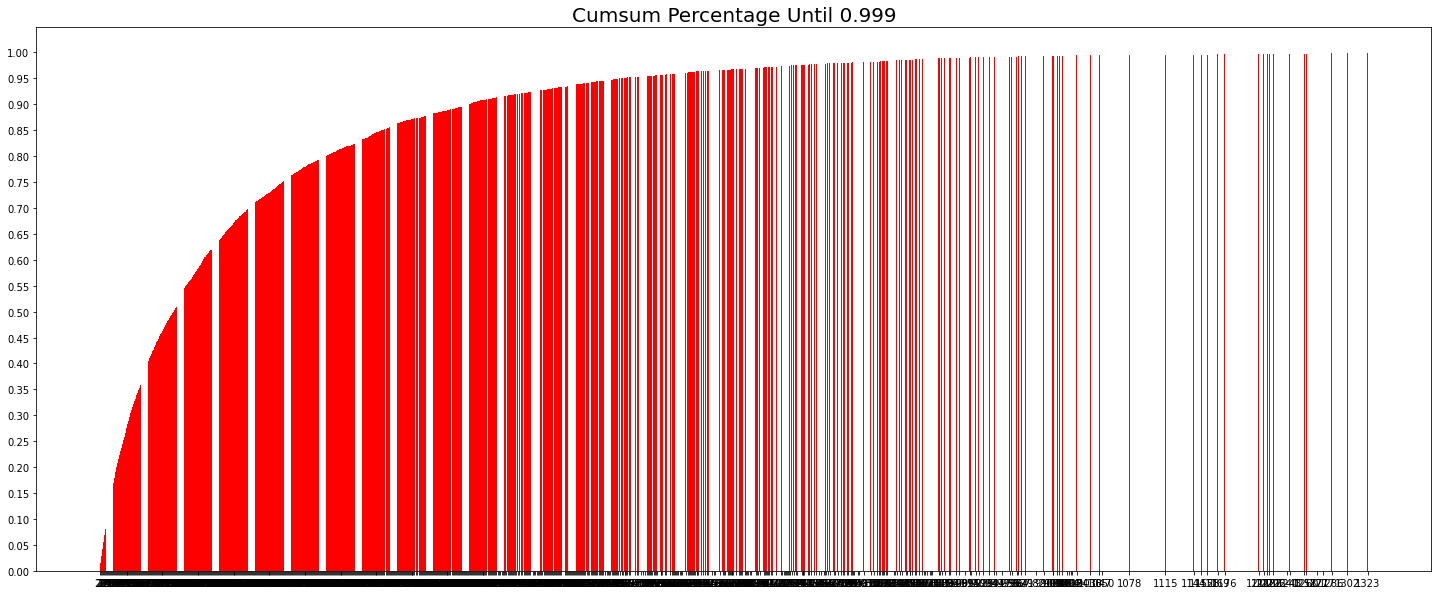

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [11]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


# 2. 미니 배치의 구성

In [12]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
#     after_date = after_date[after_date['UserId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [13]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [14]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [15]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 996825
	 Users: 6040
	 Items: 3706
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-12-30 16:54:04

* valid Set Stats Info
	 Events: 1833
	 Users: 135
	 Items: 1161
	 First Time : 2002-12-30 18:21:02
	 Last Time : 2003-01-29 17:00:13

* test Set Stats Info
	 Events: 1551
	 Users: 103
	 Items: 1008
	 First Time : 2003-01-29 19:36:56
	 Last Time : 2003-02-28 17:49:50



In [16]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [17]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 3. 모델 구성

In [18]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets


In [19]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [20]:
tr_dataset.click_offsets


array([     0,     53,    182, ..., 996361, 996484, 996825], dtype=int32)

In [21]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6037, 6038, 6039])

In [22]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [23]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [24]:
iter_ex = iter(tr_data_loader)

In [25]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


In [26]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU, LSTM
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [28]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [29]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

# Step 4. 모델 학습

In [30]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [74]:
args1 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args1)

train_model(model, args1)


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(64, 1, 3706)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      563700    
_________________________________________________________________
dropout_5 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_5 (Dense)              (64, 3706)                189006    
Total params: 752,706
Trainable params: 752,706
Non-trainable params: 0
_________________________________________________________________


Evaluation:  19%|█▉        | 5/26 [00:01<00:07,  2.95it/s]


	 - Recall@20 epoch 1: 0.087500
	 - MRR@20    epoch 1: 0.034490



Evaluation:  19%|█▉        | 5/26 [00:01<00:05,  3.50it/s]


	 - Recall@20 epoch 2: 0.109375
	 - MRR@20    epoch 2: 0.043808



Evaluation:  19%|█▉        | 5/26 [00:01<00:05,  3.54it/s]


	 - Recall@20 epoch 3: 0.115625
	 - MRR@20    epoch 3: 0.045204



Evaluation:  19%|█▉        | 5/26 [00:01<00:05,  3.53it/s]


	 - Recall@20 epoch 4: 0.112500
	 - MRR@20    epoch 4: 0.048340



Evaluation:  19%|█▉        | 5/26 [00:01<00:05,  3.55it/s]


	 - Recall@20 epoch 5: 0.112500
	 - MRR@20    epoch 5: 0.050604



Evaluation:  19%|█▉        | 5/26 [00:01<00:05,  3.59it/s]


	 - Recall@20 epoch 6: 0.115625
	 - MRR@20    epoch 6: 0.050911



Evaluation:  19%|█▉        | 5/26 [00:01<00:06,  3.46it/s]


	 - Recall@20 epoch 7: 0.121875
	 - MRR@20    epoch 7: 0.046851



Evaluation:  19%|█▉        | 5/26 [00:01<00:06,  3.43it/s]


	 - Recall@20 epoch 8: 0.121875
	 - MRR@20    epoch 8: 0.048954



Evaluation:  19%|█▉        | 5/26 [00:01<00:05,  3.51it/s]


	 - Recall@20 epoch 9: 0.115625
	 - MRR@20    epoch 9: 0.046852



Evaluation:  19%|█▉        | 5/26 [00:01<00:06,  3.44it/s]

	 - Recall@20 epoch 10: 0.115625
	 - MRR@20    epoch 10: 0.046315



In [75]:
args2 = Args(tr, val, test, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args2)

train_model(model, args2)


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(50, 1, 3706)]           0         
_________________________________________________________________
GRU (GRU)                    [(50, 50), (50, 50)]      563700    
_________________________________________________________________
dropout_6 (Dropout)          (50, 50)                  0         
_________________________________________________________________
dense_6 (Dense)              (50, 3706)                189006    
Total params: 752,706
Trainable params: 752,706
Non-trainable params: 0
_________________________________________________________________


Evaluation:  24%|██▍       | 8/33 [00:02<00:06,  3.85it/s]


	 - Recall@20 epoch 1: 0.100000
	 - MRR@20    epoch 1: 0.034218



Evaluation:  24%|██▍       | 8/33 [00:01<00:05,  4.22it/s]


	 - Recall@20 epoch 2: 0.110000
	 - MRR@20    epoch 2: 0.041744



Evaluation:  24%|██▍       | 8/33 [00:01<00:05,  4.41it/s]


	 - Recall@20 epoch 3: 0.122500
	 - MRR@20    epoch 3: 0.049681



Evaluation:  24%|██▍       | 8/33 [00:01<00:05,  4.44it/s]


	 - Recall@20 epoch 4: 0.122500
	 - MRR@20    epoch 4: 0.054175



Evaluation:  24%|██▍       | 8/33 [00:01<00:05,  4.52it/s]


	 - Recall@20 epoch 5: 0.125000
	 - MRR@20    epoch 5: 0.048269



Evaluation:  24%|██▍       | 8/33 [00:01<00:05,  4.31it/s]


	 - Recall@20 epoch 6: 0.132500
	 - MRR@20    epoch 6: 0.051275



Evaluation:  24%|██▍       | 8/33 [00:01<00:05,  4.49it/s]


	 - Recall@20 epoch 7: 0.127500
	 - MRR@20    epoch 7: 0.051242



Evaluation:  24%|██▍       | 8/33 [00:01<00:05,  4.29it/s]


	 - Recall@20 epoch 8: 0.122500
	 - MRR@20    epoch 8: 0.050314



Evaluation:  24%|██▍       | 8/33 [00:01<00:05,  4.45it/s]


	 - Recall@20 epoch 9: 0.127500
	 - MRR@20    epoch 9: 0.052424



Evaluation:  24%|██▍       | 8/33 [00:01<00:05,  4.31it/s]

	 - Recall@20 epoch 10: 0.115000
	 - MRR@20    epoch 10: 0.050044



In [76]:
args3 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args3)

train_model(model, args3)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(32, 1, 3706)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      563700    
_________________________________________________________________
dropout_7 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_7 (Dense)              (32, 3706)                189006    
Total params: 752,706
Trainable params: 752,706
Non-trainable params: 0
_________________________________________________________________


Evaluation:  36%|███▌      | 19/53 [00:03<00:05,  5.98it/s]


	 - Recall@20 epoch 1: 0.126645
	 - MRR@20    epoch 1: 0.043464



Evaluation:  36%|███▌      | 19/53 [00:02<00:05,  6.59it/s]


	 - Recall@20 epoch 2: 0.146382
	 - MRR@20    epoch 2: 0.053319



Evaluation:  36%|███▌      | 19/53 [00:03<00:05,  6.25it/s]


	 - Recall@20 epoch 3: 0.149671
	 - MRR@20    epoch 3: 0.052443



Evaluation:  36%|███▌      | 19/53 [00:02<00:05,  6.43it/s]


	 - Recall@20 epoch 4: 0.152961
	 - MRR@20    epoch 4: 0.053896



Evaluation:  36%|███▌      | 19/53 [00:02<00:05,  6.41it/s]


	 - Recall@20 epoch 5: 0.152961
	 - MRR@20    epoch 5: 0.054620



Evaluation:  36%|███▌      | 19/53 [00:02<00:05,  6.43it/s]


	 - Recall@20 epoch 6: 0.152961
	 - MRR@20    epoch 6: 0.054919



Evaluation:  36%|███▌      | 19/53 [00:02<00:05,  6.35it/s]


	 - Recall@20 epoch 7: 0.152961
	 - MRR@20    epoch 7: 0.056750



Evaluation:  36%|███▌      | 19/53 [00:02<00:05,  6.49it/s]


	 - Recall@20 epoch 8: 0.159539
	 - MRR@20    epoch 8: 0.053835



Evaluation:  36%|███▌      | 19/53 [00:02<00:05,  6.57it/s]


	 - Recall@20 epoch 9: 0.149671
	 - MRR@20    epoch 9: 0.053631



Evaluation:  36%|███▌      | 19/53 [00:03<00:05,  6.27it/s]

	 - Recall@20 epoch 10: 0.149671
	 - MRR@20    epoch 10: 0.053072



In [31]:
args4 = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model4 = create_model(args4)

train_model(model4, args4)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(16, 1, 3706)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      563700    
_________________________________________________________________
dropout (Dropout)            (16, 50)                  0         
_________________________________________________________________
dense (Dense)                (16, 3706)                189006    
Total params: 752,706
Trainable params: 752,706
Non-trainable params: 0
_________________________________________________________________


Evaluation:  48%|████▊     | 51/106 [00:06<00:07,  7.62it/s]


	 - Recall@20 epoch 1: 0.127451
	 - MRR@20    epoch 1: 0.039612



Evaluation:  48%|████▊     | 51/106 [00:06<00:06,  8.49it/s]


	 - Recall@20 epoch 2: 0.148284
	 - MRR@20    epoch 2: 0.050168



Evaluation:  48%|████▊     | 51/106 [00:06<00:06,  8.25it/s]


	 - Recall@20 epoch 3: 0.137255
	 - MRR@20    epoch 3: 0.052135



Evaluation:  48%|████▊     | 51/106 [00:06<00:06,  8.23it/s]


	 - Recall@20 epoch 4: 0.149510
	 - MRR@20    epoch 4: 0.053532



Evaluation:  48%|████▊     | 51/106 [00:06<00:06,  8.39it/s]

	 - Recall@20 epoch 5: 0.151961
	 - MRR@20    epoch 5: 0.051834



# Step 5. 모델 테스트

In [32]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [82]:
# args1 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

test_model(model1, args1, test)


Evaluation:   9%|▉         | 2/22 [00:00<00:05,  3.42it/s]

	 - Recall@20: 0.000000
	 - MRR@20: 0.000000



In [81]:
# args2 = Args(tr, val, test, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

test_model(model2, args2, test)


Evaluation:  11%|█         | 3/28 [00:00<00:07,  3.16it/s]

	 - Recall@20: 0.006667
	 - MRR@20: 0.000370



In [83]:
# args3 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

test_model(model, args3, test)


Evaluation:  18%|█▊        | 8/45 [00:01<00:05,  6.28it/s]

	 - Recall@20: 0.128906
	 - MRR@20: 0.052268



In [33]:
# args4 = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

test_model(model4, args4, test)

Evaluation:  34%|███▍      | 31/90 [00:03<00:07,  7.96it/s]

	 - Recall@20: 0.135081
	 - MRR@20: 0.051651



- hsz는 50으로 drop_rate은 0.1로, lr은 0.001로, 그리고 k는 20으로 유지하였습니다. 
- batch_size는 64 -> 50 -> 32 -> 16 으로 줄이면서 결과를 확인 해봤습니다. 
    - Recall@20는 0.000000 -> 0.006667 -> 0.128906 -> 0.135081 로 증가하였습니다. 
    - MRR@20는 0.000000 -> 0.000370 -> 0.052268 -> 0.051651 로 증가하였습니다. 
- batch_size가 50에서 32 줄었을 때, Recall과 MRR 값이 가장 좋아지는 결과를 보였습니다. 